In [56]:
import pandas as pd
import numpy as np
import time

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import iplot

---
### Sub：Metrics

In [58]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [59]:
# 顯示比較圖表，可以選擇是否儲存
def showPlot(true, prediction, title , sub_title, size='M', save=False):
    if(size=='L'):
        plt.figure(figsize=(28, 10))
    plt.plot(true, color = 'red', label = 'Real')
    plt.plot(prediction, color = 'blue', label = 'Prediction')
    plt.title('Industry Elec Prediction' + title + ' ' + sub_title + ' t' + str(t))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    if(save):
        plt.savefig('Image/' + title + '-' + sub_title + '-' + str(t) + '.png')
    plt.show()

---
### Sub：Data Processing

In [60]:
# 資料維度擷取
def augFeatures(data, features_select):
    data = pd.DataFrame(data[features_select])
    data.shape
    return data

In [61]:
# 資料正規化 & 尺度還原
from sklearn.preprocessing import MinMaxScaler
def normalize(data):
    sc = MinMaxScaler(feature_range = (0, 1))
    data_scaled = pd.DataFrame(sc.fit_transform(data))
    return sc, data_scaled 

def deNormalize(sc, value):
    value_unscaled = value * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
    return value_unscaled 

In [62]:
def split_dataset(data, pastDay=7, futureDay=7):
    split_num_start = df[df['Date'] == trainFrom].index.item()
    split_num = df[df['Date'] == testFrom].index.item()
    split_num_end = df[df['Date'] == testTo].index.item()
    RawTrain = data[split_num_start:split_num]
    SelfTest = data[split_num_start:split_num - futureDay]
    SelfTruth = data[split_num_start + pastDay:split_num][0]
    RawTest = data[split_num - pastDay:split_num_end + 1 - futureDay]
    RawTrurh = data[split_num:split_num_end + 1][0]
    print("RawTrain", RawTrain.shape)
    print("RawTest, RawTrurh", RawTest.shape, RawTrurh.shape)
    print("SelfTest, SelfTruth", SelfTest.shape, SelfTruth.shape)
    return RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth

In [63]:
def buildTrain(train, pastDay=7, futureDay=7):
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)  
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    return X_train, Y_train

In [64]:
def buildTest(test, pastDay=7, futureDay=7):
    X_test = []
    for i in range(0, int(len(test)/futureDay)-(pastDay-futureDay)):
        X_test.append(test[futureDay*i:futureDay*i+pastDay])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  
    return X_test

In [76]:
def splitData(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [65]:
def forecast(model, input_data, shape):
    forecast_temp = model.predict(input_data)
    forecast = []
    for i in range(forecast_temp.shape[0]):
        forecast= np.concatenate((forecast, forecast_temp[i]), axis=0)
    forecast = np.reshape(forecast, (shape[0], shape[1]))
    return forecast

---
### Sub：Model
Configuring the Keras Model for Talos

In [66]:
import sys
import talos

In [67]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten, RepeatVector, Activation
from keras.layers import SimpleRNN, LSTM, CuDNNLSTM
from keras.layers import Dropout, BatchNormalization, Bidirectional
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [69]:
# first we have to make sure to input data and params into the function
def create_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(CuDNNLSTM(units = params['layer_1_node'], input_shape = (x_train.shape[1], x_train.shape[2])))
    model.add(Activation(params['activation']))
    model.add(RepeatVector(7))
    
    model.add(CuDNNLSTM(params['layer_2_node'], return_sequences=True))
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout']))
    
    model.add(TimeDistributed(Dense(params['layer_3_node'], activation='relu')))
    model.add(Dropout(params['dropout']))
    model.add(Flatten())
    model.add(Dense(units = 7))
    
    optimizer = optimizers.Adam(lr=params['learning_rate'], beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer = optimizer, loss = params['losses'], metrics=['mae'])
    
    model.compile(optimizer = 'Adam', 
                  loss = params['losses'], 
                  metrics=['mse', talos.utils.metrics.mae])
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=params['lr_reduce_rate'], patience=20, mode='min', verbose=0)
    earlyStop=EarlyStopping(monitor="val_loss", patience=50, mode="min", restore_best_weights=True)
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        epochs=1000, batch_size=params['batch_size'],
                        verbose=0, 
                        callbacks=[reduce_lr, earlyStop])
    return history, model    

In [70]:
p = {'losses': ['mean_squared_error'],
#      'lr': [0.0001, 0.1],
     'activation':['relu', 'elu'],
     'learning_rate': [0.0001,0.001,0.01,0.1],
     'lr_reduce_rate': [0.001, 0.01, 0.1, 0.3, 0.5],
     'dropout': (0.0, 0.5, 0.1),
     'layer_1_node': [50, 100, 200, 300, 400],
     'layer_2_node': [50, 100, 200, 300, 400],
     'layer_3_node': [50, 100, 200, 300, 400],
     'batch_size': [16, 32, 64, 128]
    }

---
### Main

In [71]:
df = pd.read_csv('Data/industryElec_processed_20160101_20190930.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.shape

(1369, 12)

In [72]:
features = [
            'kW', 
            'PeakLoad(MW)_shift7', 
            'isHoliday_shift7', 
            'dayOfYear', 
            'weekUpdate_shift7', 
            'Temp_Taipei_shift7'
           ]

In [73]:
trainFrom = '2017-01-04'
trainTo = '2019-01-01'
testFrom = '2019-01-02'
testTo = '2019-09-24'

In [74]:
# 特徵選取
RawData = augFeatures(df, features)
# 正規化
sc, RawData = normalize(RawData)

In [101]:
# 自定義變數
Timesteps = 7
OutputDay = 7

# 資料選取
RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth  = split_dataset(RawData, Timesteps, OutputDay)

# 資料打包
X_train, Y_train = buildTrain(RawTrain.values, Timesteps, OutputDay)
S_test = buildTest(SelfTest.values, Timesteps, OutputDay)
X_test = buildTest(RawTest.values, Timesteps, OutputDay)

# 驗證資料
X, Y, Xv, Yv= splitData(X_train, Y_train, 0.3)

RawTrain (728, 6)
RawTest, RawTrurh (266, 6) (266,)
SelfTest, SelfTruth (721, 6) (721,)


In [87]:
%%time
# run the experiment
scan_object = talos.Scan(x=X_train, y=Y_train, val_split=0.1,
                         model=create_model,
                         params=p,
                         reduction_metric='val_loss', minimize_loss=True,
                         # round_limit=5,
                         grid_downsample=0.01
                         experiment_name='breast_cancer',
                         experiment_no='2')


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:36<00:00, 67.24s/it]

Wall time: 5min 36s


In [94]:
hypers = t
hypers_head = hypers.data.sort_values(["val_mae"],ascending=True).head(10)
hypers_head

,round_epochs,val_loss,val_mae,val_f1score,loss,mae,f1score,lr,activation,batch_size,dropout,layer_1_node,layer_2_node,layer_3_node,learning_rate,losses,lr_reduce_rate
4,185,0.001269,0.026982,0.420887,0.000819,0.021388,0.473800,1.000000e-08,relu,32,0.0,300,100,200,0.0010,mean_squared_error,0.10
3,203,0.001566,0.028546,0.388960,0.000973,0.022973,0.476158,8.100000e-06,relu,64,0.0,100,300,400,0.0001,mean_squared_error,0.30
0,160,0.001485,0.028836,0.427523,0.001010,0.023648,0.491523,1.000000e-11,relu,32,0.0,300,200,300,0.0001,mean_squared_error,0.01
2,237,0.001500,0.029986,0.442244,0.000892,0.022767,0.476783,3.906250e-06,elu,16,0.0,100,400,50,0.1000,mean_squared_error,0.50
1,276,0.001923,0.034063,0.396886,0.001529,0.029784,0.494097,7.812500e-06,elu,64,0.0,100,200,300,0.1000,mean_squared_error,0.50


In [187]:
evaluate_object = talos.Evaluate(t)
evaluation = evaluate_object.evaluate(Xv, Yv, folds=10, 
                         metric='val_loss', asc=True,
                         task='multi_label')

In [129]:
t.evaluate_models(x_val=Xv,
                  y_val=Yv,
                  n_models=10,
                  metric='val_mae',
                  asc=True,
                  folds=5,
                  shuffle=False,
                  task='multi_label')


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.79s/it]

>> Added evaluation score columns to scan_object.data


In [130]:
t.data

,round_epochs,val_loss,val_mae,val_f1score,loss,mae,f1score,lr,activation,batch_size,dropout,layer_1_node,layer_2_node,layer_3_node,learning_rate,losses,lr_reduce_rate,eval_f1score_mean,eval_f1score_std
0,160,0.001485,0.028836,0.427523,0.001010,0.023648,0.491523,1.000000e-11,relu,32,0.0,300,200,300,0.0001,mean_squared_error,0.01,0.517169,0.151697
1,276,0.001923,0.034063,0.396886,0.001529,0.029784,0.494097,7.812500e-06,elu,64,0.0,100,200,300,0.1000,mean_squared_error,0.50,0.459240,0.157393
2,237,0.001500,0.029986,0.442244,0.000892,0.022767,0.476783,3.906250e-06,elu,16,0.0,100,400,50,0.1000,mean_squared_error,0.50,0.506652,0.137484
3,203,0.001566,0.028546,0.388960,0.000973,0.022973,0.476158,8.100000e-06,relu,64,0.0,100,300,400,0.0001,mean_squared_error,0.30,0.487438,0.122158
4,185,0.001269,0.026982,0.420887,0.000819,0.021388,0.473800,1.000000e-08,relu,32,0.0,300,100,200,0.0010,mean_squared_error,0.10,0.523791,0.168933


In [132]:
t.learning_entropy

,loss,mae,f1score,lr
0,4.091128,4.936938,5.073883,4.363665
1,4.923473,5.531501,5.618527,5.221425
2,5.013634,5.404473,5.467715,4.890572
3,4.130462,5.143682,5.310441,4.983699
4,4.166060,5.075781,5.219019,4.544258


#### Analysing the Scan results with Reporting()

In [139]:
# use Scan object as input
analyze_object = talos.Analyze(t)

In [140]:
# access the dataframe with the results
analyze_object.data

,round_epochs,val_loss,val_mae,val_f1score,loss,mae,f1score,lr,activation,batch_size,dropout,layer_1_node,layer_2_node,layer_3_node,learning_rate,losses,lr_reduce_rate,eval_f1score_mean,eval_f1score_std
0,160,0.001485,0.028836,0.427523,0.001010,0.023648,0.491523,1.000000e-11,relu,32,0.0,300,200,300,0.0001,mean_squared_error,0.01,0.517169,0.151697
1,276,0.001923,0.034063,0.396886,0.001529,0.029784,0.494097,7.812500e-06,elu,64,0.0,100,200,300,0.1000,mean_squared_error,0.50,0.459240,0.157393
2,237,0.001500,0.029986,0.442244,0.000892,0.022767,0.476783,3.906250e-06,elu,16,0.0,100,400,50,0.1000,mean_squared_error,0.50,0.506652,0.137484
3,203,0.001566,0.028546,0.388960,0.000973,0.022973,0.476158,8.100000e-06,relu,64,0.0,100,300,400,0.0001,mean_squared_error,0.30,0.487438,0.122158
4,185,0.001269,0.026982,0.420887,0.000819,0.021388,0.473800,1.000000e-08,relu,32,0.0,300,100,200,0.0010,mean_squared_error,0.10,0.523791,0.168933


In [149]:
# get the number of rounds in the Scan
# print('analyze_object.rounds()', analyze_object.rounds())

# get the highest result for any metric
analyze_object.low('val_loss')

# get the round with the best result
analyze_object.rounds2high('val_mae')

# get the best paramaters
# analyze_object.best_params('val_mae', ['mae', 'loss', 'val_loss'])

# get correlation for hyperparameters against a metric
analyze_object.correlate('val_loss', ['mae', 'loss', 'val_loss'])

round_epochs         0.776595
val_mae              0.952015
val_f1score         -0.526370
f1score              0.703672
lr                   0.760950
batch_size           0.653612
dropout                   NaN
layer_1_node        -0.659815
layer_2_node         0.184213
layer_3_node         0.333528
learning_rate        0.623753
lr_reduce_rate       0.653103
eval_f1score_mean   -0.951877
eval_f1score_std    -0.145241
Name: val_loss, dtype: float64

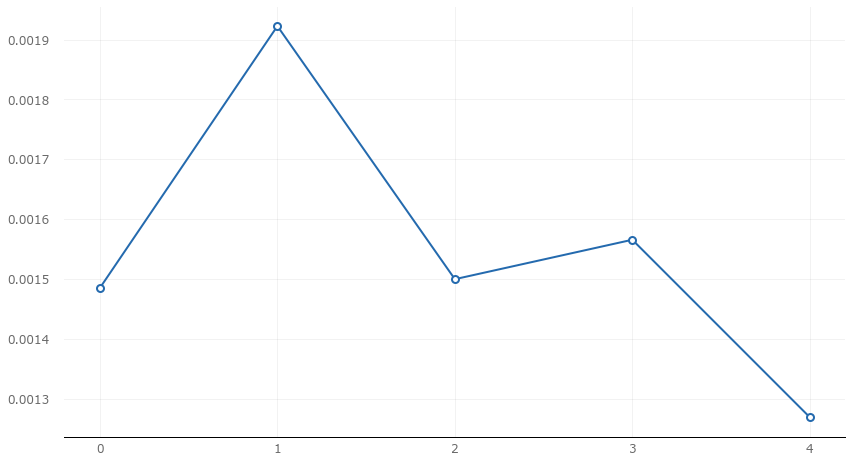

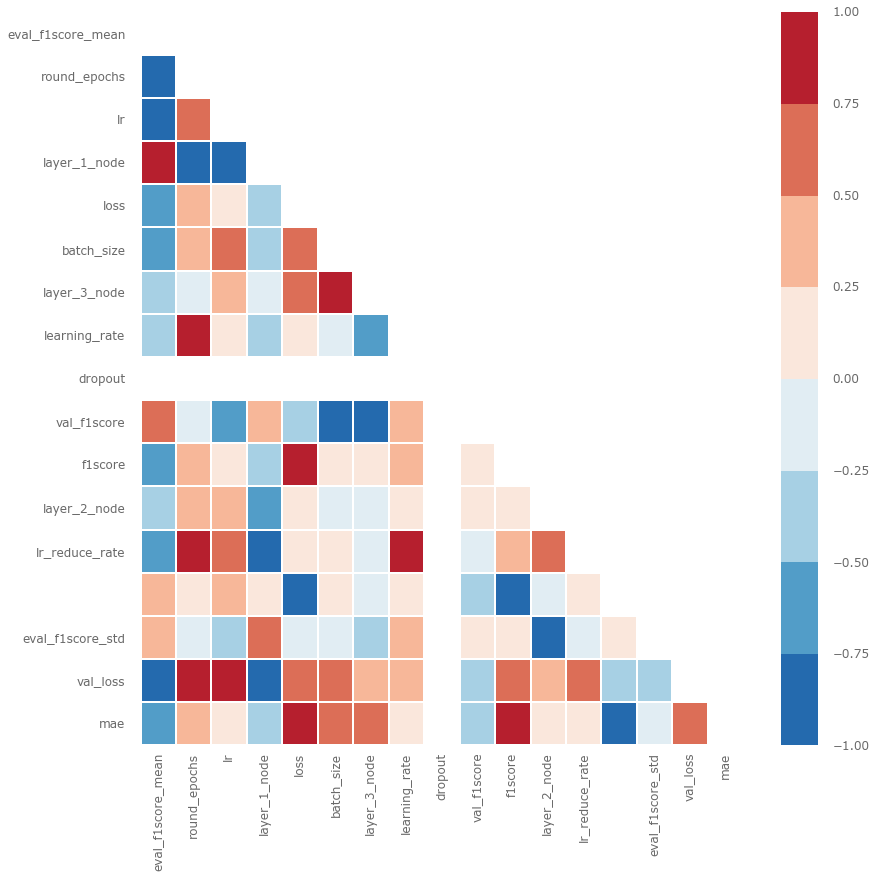

In [193]:
# line plot
# analyze_object.plot_line('val_mae')
analyze_object.plot_line('val_loss')

# up to two dimensional kernel density estimator
# analyze_object.plot_kde('val_loss')

# heatmap correlation
analyze_object.plot_corr('val_loss', ['val_mae', 'val_loss'])

# a four dimensional bar grid
# analyze_object.plot_bars('batch_size', 'val_mae', 'layer_1_node', 'lr')

In [83]:
# 輸出資料
dfOut = pd.DataFrame(hypers_head)
dfOut.to_csv('talos_hypers_temp.csv')

In [171]:
t = 4
save = False
model_name = '(XT_RNN_2017_Hyperas_BAD)'

In [180]:
p = Predict('scan_object')

p.predict(x)

NameError: name 'Predict' is not defined

In [ ]:
self_trurh = pd.DataFrame(SelfTruth)
self_trurh = deNormalize(sc, self_trurh.values)
self_predict = forecast(best_model, S_test, self_trurh.shape)
self_predict = deNormalize(sc, self_predict)
calcError(self_trurh, self_predict)
showPlot(self_trurh, self_predict, model_name , "self", size="L", save=save)

In [ ]:
test_trurh = pd.DataFrame(RawTrurh)
test_trurh = deNormalize(sc, test_trurh.values)
test_predict = forecast(best_model, X_test, test_trurh.shape)
test_predict = deNormalize(sc, test_predict)
calcError(test_trurh, test_predict)
showPlot(test_trurh, test_predict, model_name , str(266), save=save)